In [121]:
import os
import sys 
import glob
import copy
import xrft
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from velocity_leakage import S1DopplerLeakage
from add_dca import DCA

In [122]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

## Find DCA files

In [123]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios

['Aghulas_20190510',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Aghulas_20200426',
 'Aghulas_20200402',
 'Aghulas_20190515',
 'Aghulas_20200321']

In [125]:
scenario = 'Aghulas_20200321'
files_dca = glob.glob(f"{data_dir+scenario}/*.nc")
# files_dca = [file for file in files_dca if 'S1B' in file]
files_dca

['/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173505-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173530-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173440-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173413-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173258-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173323-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173348-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20200321/20200321T173233-WOC-L2P-CUReul-S1A-OSC_RVL-v1.0-fv1

## Calculate leakage for synthetic scatterometer

In [126]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Aghulas_20200426',
 'Scotland_20231109',
 'Aghulas_20200402',
 'Aghulas_20190515',
 'Aghulas_20200321']

In [241]:
scenario = 'Aghulas_20200321'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

observation = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    antenna_length=3.2,
    beam_pattern='phased_array',
    # _speckle_noise=False,
    )

In [242]:
observation.apply()#antenna_elements = 4)

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200321/0407_0528_2434_7A73_BC55_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20200321h1800_lat-34_87_lon17_94.nc


## - Interpolate and add DCA to Sentinel-1

In [243]:
obj_copy = copy.deepcopy(observation)

dca_interp = DCA(filenames=files_dca,
    latitudes=obj_copy.S1_file.latitude.values,
    longitudes=obj_copy.S1_file.longitude.values).add_dca()

In [244]:
obj_copy.create_dataset()
obj_copy.data['dca_s1'] = (['az', 'grg'], dca_interp)
obj_copy.create_beam_mask()

In [245]:
numerator = obj_copy.data['dca_s1'] * np.cos(np.deg2rad(90 - observation.data['inc']))
denominator = np.cos(np.deg2rad(90 - observation.data['inc_scatt_eqv']))
obj_copy.data['dca_scatt'] = numerator / denominator

In [246]:
# compute weighted received Doppler and resulting apparent LOS velocity
observation.data['dop_beam_weighted_w_dca'] = (obj_copy.data.dca_scatt + observation.data['dop_geom']) * observation.data['beam']* observation.data['nrcs_weight']
observation.data['dca_beam_weighted'] = obj_copy.data.dca_scatt * observation.data['beam'] * observation.data['nrcs_weight']

# sum over azimuth to receive range-slow_time results
weight_rg = (observation.data['beam'] * observation.data['nrcs_weight']).sum(dim='az_idx', skipna=False)
receive_rg = observation.data['dop_beam_weighted_w_dca'].sum(dim='az_idx', skipna=False)
observation.data[['dca_pulse_rg']] = observation.data['dca_beam_weighted'].sum(dim='az_idx', skipna=False) / weight_rg
observation.data[['doppler_w_dca_pulse_rg']] = receive_rg / weight_rg

observation.data['doppler_w_dca_pulse_rg_subscene'] = observation.data['doppler_w_dca_pulse_rg'].rolling(grg=observation.grg_N, slow_time=observation.slow_time_N, center=True).mean()
observation.data['dca_pulse_rg_subscene'] = observation.data['dca_pulse_rg'].rolling(grg=observation.grg_N, slow_time=observation.slow_time_N, center=True).mean()

observation.data = observation.data.transpose('az_idx', 'grg', 'slow_time')

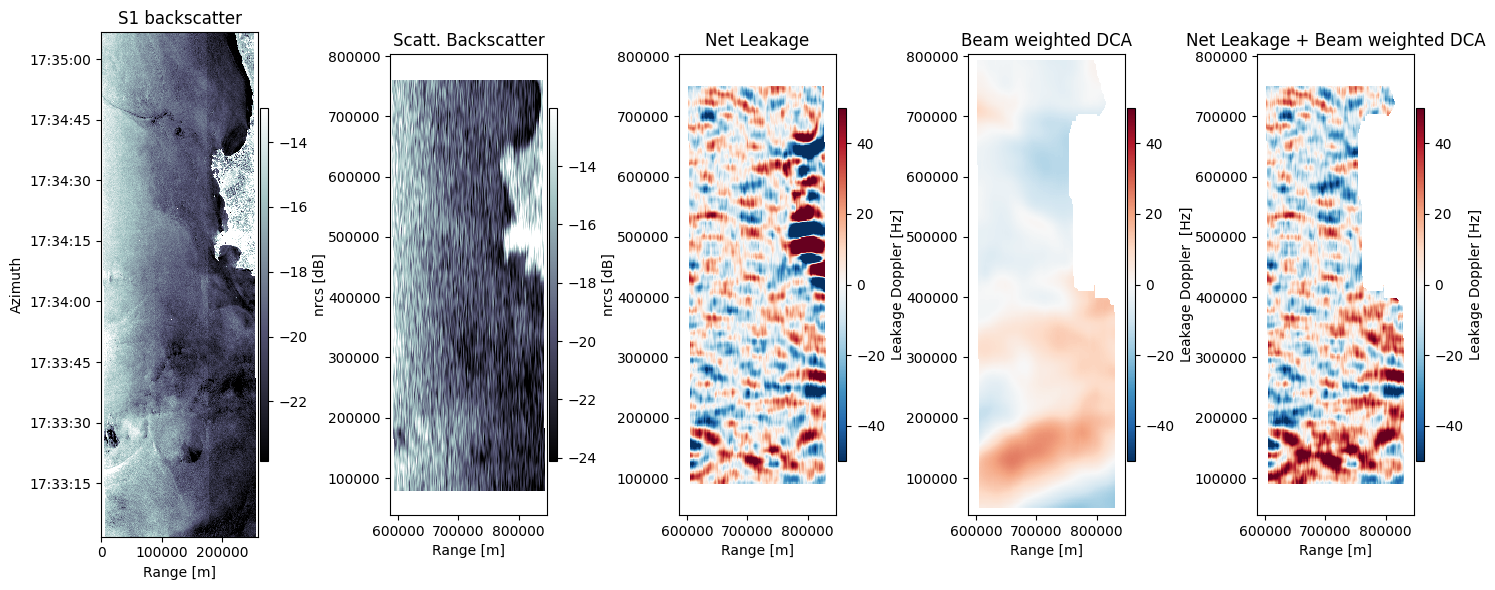

In [247]:
cbar_kwargs = {'shrink':0.7, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -50, 'vmax': 50, 'cmap' : 'RdBu_r'}
plot_leakage_net_kwargs = {'vmin': -2, 'vmax': 2, 'cmap' : 'PiYG'}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = observation.data['doppler_pulse_rg_subscene']- observation.data['doppler_pulse_rg_subscene_inverted']

nx = 5; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (15, 6), sharex=False, sharey=False)

(10*np.log10(observation.S1_file['NRCS_VV'])).plot(ax= axes[0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})

(10*np.log10(observation.data['nrcs_scat_w_noise'])).T.plot(ax= axes[1], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
net_leakage.T.plot(ax= axes[2], 
                                                  **{**plot_leakage_kwargs},
                                                  cbar_kwargs = {'label':'Leakage Doppler [Hz]', **cbar_kwargs})
observation.data['dca_pulse_rg_subscene'].T.plot(ax= axes[3], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Doppler  [Hz]', **cbar_kwargs})
(observation.data['dca_pulse_rg_subscene'] + net_leakage).T.plot(ax= axes[4],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Doppler [Hz]', **cbar_kwargs})


titles = ['S1 backscatter', 'Scatt. Backscatter', 'Net Leakage', 'Beam weighted DCA', 'Net Leakage + Beam weighted DCA']
x_labels = ['Range [m]'] * nx
y_labels = ['Azimuth'] + [''] * (nx - ny)
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()[1:]]

plt.tight_layout()

In [248]:
from scipy.signal import convolve2d

net_leakage = observation.data['doppler_pulse_rg']- observation.data['doppler_pulse_rg_inverted']


t = []
for i in range(3, 12):
    n = i
    gradient_kernel = np.array([np.sin(2*np.pi*np.linspace(0,1, n))/n])

    convolved_data = convolve2d(net_leakage.values, gradient_kernel, mode='same')

    t.append(xr.DataArray(convolved_data, coords=net_leakage.coords, dims=net_leakage.dims))

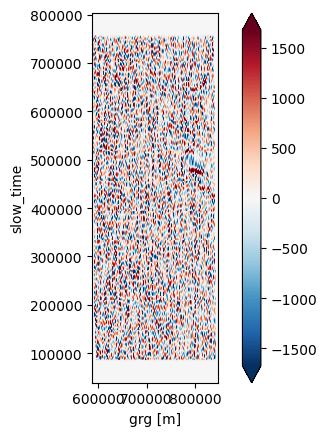

In [249]:
stacked = xr.concat(t, dim='z').sum(dim='z')#.rolling(grg=observation.grg_N, slow_time=observation.slow_time_N, center=True).mean()
ax = stacked.T.plot(robust = True)
ax.axes.set_aspect('equal')

In [250]:
net_leakage_clipped = net_leakage.sel(slow_time = slice(100e3, 750e3))
net_leakage_clipped = net_leakage_clipped.assign_coords(slow_time=net_leakage_clipped.slow_time - (net_leakage_clipped.slow_time.mean()))#.T.plot()

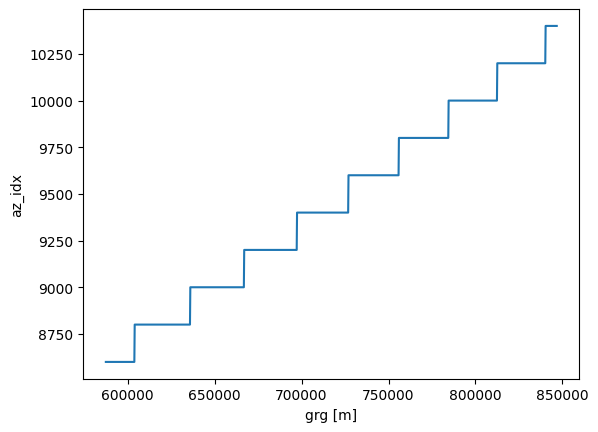

In [277]:
in_db = 10*np.log10(observation.data.beam)
# in_db.plot(robust = True)
t = ((in_db  - in_db.max(dim = 'az_idx')) > -6)
(40e3 - t.az_idx[t.argmax(dim='az_idx')]).plot()

In [265]:
observation.grg_N

125

/Users/opodriscoll/miniconda3/envs/xarray_sentinel/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


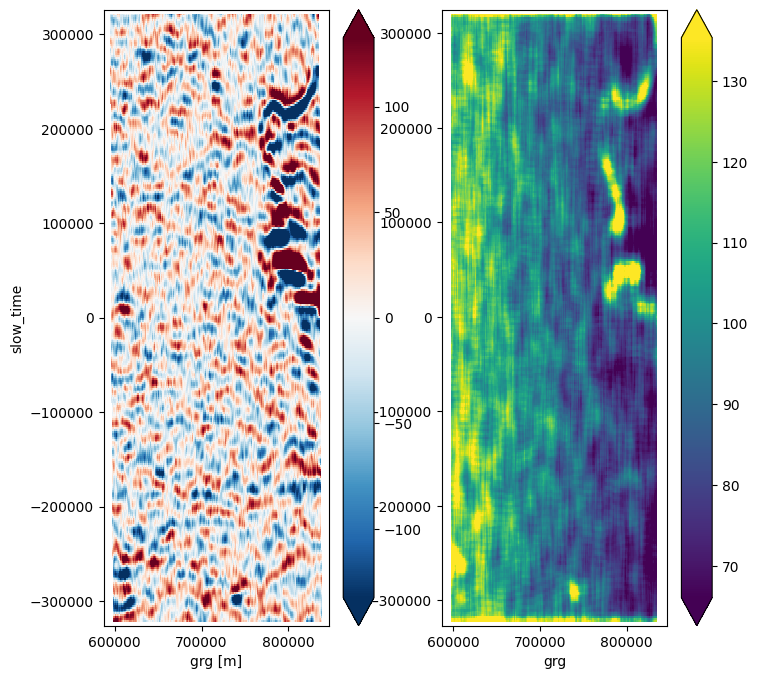

In [284]:

L = xrft.fft(net_leakage_clipped,
             dim = 'slow_time',
            #  window = 'hann'
)

highpass_limit = 8e3 # km 
lowpass_limit = 20e3 # km
condition = (abs(L.freq_slow_time) > 1 / highpass_limit) |  (abs(L.freq_slow_time) < 1 / lowpass_limit)
L_hp = xr.where(condition, 0, L)


N_grg = 50; N_st = 5 # observation.slow_time_N//8
l = abs(xrft.ifft(L_hp, dim = 'freq_slow_time')).rolling(grg=N_grg, slow_time=N_st, center=True).mean()


fig, axes = plt.subplots(1, 2, figsize = (8, 8), sharex=False, sharey=False)

ax = np.real(l).plot(ax = axes[1], robust = True)
net_leakage_clipped.T.rolling(grg=N_grg, slow_time=N_st, center=True).mean().plot(ax= axes[0], robust = True)


# ax.axes.set_aspect('equal')